In [46]:
%pip install segmentation_models

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: segmentation_models in c:\users\gabri\appdata\local\programs\python\python311\lib\site-packages (1.0.1)




[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import re
import argparse

os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm



Segmentation Models: using `tf.keras` framework.


In [3]:
from src.models.resnet import ResNet18, load_encoder_weights, ResNet50_tf
from src.libs.data_loading import create_dataset_segmentation

In [124]:
def iou_metric(
    y_true: tf.Tensor, y_pred: tf.Tensor, num_classes: int = 3, threshold: float = 0.5
):
    class_iou = []
    for class_idx in range(num_classes):
        # Generate binary vector from predictions
        y_pred = tf.where(y_pred > threshold, 1.0, 0.0)

        # Extract single class to compute IoU over
        y_true_single_class = y_true[..., class_idx]
        y_pred_single_class = y_pred[..., class_idx]

        # Compute IoU
        intersection = K.sum(y_true_single_class * y_pred_single_class)
        union = K.sum(y_true_single_class) + K.sum(y_pred_single_class) - intersection

        class_iou.append(K.switch(K.equal(union, 0.0), 1.0, intersection / union))

    return sum(class_iou) / len(class_iou)

In [125]:
import tensorflow as tf
from tensorflow.keras import backend as K

def iou_metric(
    y_true: tf.Tensor, y_pred: tf.Tensor, num_classes: int = 3, threshold: float = 0.5
) -> tf.Tensor:
    # Binarize predictions
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)

    # Initialize list to store IoU for each class
    ious = []

    for class_idx in range(num_classes):
        # Extract predictions and ground truth for the current class
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred_bin[..., class_idx]

        # Compute intersection and union
        intersection = tf.reduce_sum(y_true_class * y_pred_class, axis=(1, 2))  # Sum over spatial dimensions
        union = (
            tf.reduce_sum(y_true_class, axis=(1, 2))
            + tf.reduce_sum(y_pred_class, axis=(1, 2))
            - intersection
        )

        # Avoid division by zero by using a conditional operation
        iou = tf.where(union > 0, intersection / union, tf.ones_like(union))
        ious.append(iou)

    # Compute mean IoU over all classes
    mean_iou = tf.reduce_mean(tf.stack(ious, axis=0), axis=0)  # Average over classes

    return tf.reduce_mean(mean_iou)  # Average over batch


class TrainingProgressCallback(tf.keras.callbacks.Callback):
    """Custom callback to track and save training progress."""

    def __init__(self, checkpoint_dir="models", save_freq=1):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
        self.save_freq = save_freq
        self.best_val_loss = float("inf")
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Load existing history if it exists
        history_path = os.path.join(checkpoint_dir, "training_history.npy")
        if os.path.exists(history_path):
            try:
                self.history = np.load(history_path, allow_pickle=True).item()
            except:
                self.history = self._initialize_history()
        else:
            self.history = self._initialize_history()

        # Load best validation loss if it exists
        best_loss_path = os.path.join(checkpoint_dir, "best_val_loss.npy")
        if os.path.exists(best_loss_path):
            self.best_val_loss = float(np.load(best_loss_path))

    def _initialize_history(self):
        return {"loss": [], "val_loss": [], "iou_metric": [], "val_iou_metric": [], "lr": []}

    def on_epoch_end(self, epoch, logs=None):
        # Update history with available logs
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])
            elif metric == "lr":
                # Manually get current learning rate
                lr = K.get_value(self.model.optimizer.learning_rate)
                self.history["lr"].append(lr)

        # Save periodic checkpoint
        if (epoch + 1) % self.save_freq == 0:
            checkpoint_path = os.path.join(
                self.checkpoint_dir, f"segmentation_model_epoch_{epoch + 1:03d}.h5"
            )
            self.model.save_weights(checkpoint_path)
            print(f"\nSaved periodic checkpoint for epoch {epoch + 1}")

        # Save best model
        if logs.get("val_loss", float("inf")) < self.best_val_loss:
            self.best_val_loss = logs["val_loss"]
            best_model_path = os.path.join(self.checkpoint_dir, "best_segmentation_model.h5")
            self.model.save_weights(best_model_path)
            # Save best validation loss
            np.save(os.path.join(self.checkpoint_dir, "best_val_loss.npy"), self.best_val_loss)
            print(f"\nNew best model saved with validation loss: {self.best_val_loss:.6f}")

        # Save training history
        history_path = os.path.join(self.checkpoint_dir, "training_history.npy")
        np.save(history_path, self.history)


def _gather_channels(x, indexes, **kwargs):
    """Slice tensor along channels axis by given indexes"""
    if tf.keras.backend.image_data_format() == 'channels_last':
        x = tf.keras.permute_dimensions(x, (3, 0, 1, 2))
        x = tf.keras.gather(x, indexes)
        x = tf.keras.permute_dimensions(x, (1, 2, 3, 0))
    else:
        x = tf.keras.permute_dimensions(x, (1, 0, 2, 3))
        x = tf.keras.gather(x, indexes)
        x = tf.keras.permute_dimensions(x, (1, 0, 2, 3))
    return x

def gather_channels(*xs, indexes=None, **kwargs):
    """Slice tensors along channels axis by given indexes"""
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes, **kwargs) for x in xs]
    return xs


def round_if_needed(x, threshold, **kwargs):
    if threshold is not None:
        x = tf.keras.greater(x, threshold)
        x = tf.keras.cast(x, tf.keras.floatx())
    return x


def average(x, per_image=False, class_weights=None, **kwargs):
    if per_image:
        x = tf.math.reduce_mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return tf.math.reduce_mean(x)


def get_reduce_axes(per_image, **kwargs):
    axes = [1, 2] if tf.keras.backend.image_data_format() == 'channels_last' else [2, 3]
    if not per_image:
        axes.insert(0, 0)
    return axes


def iou_score(gt, pr, class_weights=1., class_indexes=None, smooth=1e-5, per_image=False, threshold=None, **kwargs):

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    #pr = round_if_needed(pr, threshold, **kwargs)
    class_indices = tf.argmax(pr, axis=-1)
    pr = tf.one_hot(class_indices, depth=11)
    pr = tf.cast(pr, dtype=gt.dtype)

    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    intersection = tf.math.reduce_sum(gt * pr, axis=axes)
    union = tf.math.reduce_sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


class IOUScore:

    def __init__(
            self,
            class_weights=None,
            class_indexes=None,
            threshold=None,
            per_image=False,
            smooth=1e-5,
            name=None,
    ):
        name = name or 'iou_score'
        self.class_weights = class_weights if class_weights is not None else 1
        self.class_indexes = class_indexes
        self.threshold = threshold
        self.per_image = per_image
        self.smooth = smooth

    def __call__(self, gt, pr):
        return iou_score(
            gt,
            pr,
            class_weights=self.class_weights,
            class_indexes=self.class_indexes,
            smooth=self.smooth,
            per_image=self.per_image,
            threshold=self.threshold
        )

class FScore:

    def __init__(
            self,
            beta=1,
            class_weights=None,
            class_indexes=None,
            threshold=None,
            per_image=False,
            smooth=1e-5,
            name=None,
    ):
        name = name or 'f{}-score'.format(beta)
        self.beta = beta
        self.class_weights = class_weights if class_weights is not None else 1
        self.class_indexes = class_indexes
        self.threshold = threshold
        self.per_image = per_image
        self.smooth = smooth

    def __call__(self, gt, pr):
        return f_score(
            gt,
            pr,
            beta=self.beta,
            class_weights=self.class_weights,
            class_indexes=self.class_indexes,
            smooth=self.smooth,
            per_image=self.per_image,
            threshold=self.threshold,
        )

def f_score(gt, pr, beta=1, class_weights=1, class_indexes=None, smooth=1e-5, per_image=False, threshold=None,
            **kwargs):


    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    class_indices = tf.argmax(pr, axis=-1)
    pr = tf.one_hot(class_indices, depth=11)
    pr = tf.cast(pr, dtype=gt.dtype)
    axes = get_reduce_axes(per_image, **kwargs)

    # calculate score
    tp = tf.math.reduce_sum(gt * pr, axis=axes)
    fp = tf.math.reduce_sum(pr, axis=axes) - tp
    fn = tf.math.reduce_sum(gt, axis=axes) - tp

    score = ((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score



def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs=10,
    initial_epoch=0,
    checkpoint_dir="models",
    load_latest_checkpoint=True,
):
    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Create a TensorFlow checkpoint
    checkpoint = tf.train.Checkpoint(model=model)
    checkpoint_manager = tf.train.CheckpointManager(
        checkpoint, directory=checkpoint_dir, max_to_keep=5
    )

    # Determine if we should load the latest checkpoint
    if load_latest_checkpoint:
        latest_checkpoint = checkpoint_manager.latest_checkpoint
        if latest_checkpoint:
            try:
                # Restore the checkpoint
                checkpoint.restore(latest_checkpoint).expect_partial()

                # Extract epoch number from checkpoint filename
                epoch_match = re.search(r"ckpt-(\d+)", latest_checkpoint)
                if epoch_match:
                    initial_epoch = int(epoch_match.group(1))

                print(f"Loaded checkpoint from epoch {initial_epoch}")
            except Exception as e:
                print(f"Error loading checkpoint: {e}")
                print("Starting training from scratch...")
                initial_epoch = 0


    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    # set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
    class_weights = np.array([0.5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0.5])
    #class_weights = np.array([1., 5., 15., 11., 10., 8., 10., 5., 6., 14., 0.5])
    dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)

    metrics = [IOUScore(), FScore()]

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=total_loss,
        #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=metrics,
    )

    # Create callbacks for training
    class CustomCheckpointCallback(tf.keras.callbacks.Callback):
        def __init__(self, checkpoint_dir):
            super().__init__()
            self.checkpoint_dir = checkpoint_dir

        def on_epoch_end(self, epoch, logs=None):
            # Save TensorFlow checkpoint
            checkpoint_manager.save()

            # Save H5 checkpoint
            h5_path = os.path.join(
                self.checkpoint_dir, f"segmentation_model_epoch_{epoch + 1:03d}.h5"
            )
            self.model.save_weights(h5_path)
            print(f"\nSaved H5 checkpoint for epoch {epoch + 1}")

    callbacks = [
        CustomCheckpointCallback(checkpoint_dir),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0, patience=5, verbose=1, mode="auto"
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, verbose=1, mode="auto"
        ),
    ]

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        initial_epoch=initial_epoch,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
    )

    return model, history


def get_latest_checkpoint(checkpoint_dir):
    """Find the latest checkpoint file and extract its epoch number."""
    # First, look for H5 checkpoints
    import glob
    import re

    h5_files = sorted(
        glob.glob(os.path.join(checkpoint_dir, "segmentation_model_epoch_*.h5")),
        key=lambda x: int(re.search(r"epoch_(\d+)\.h5", x).group(1)),
    )

    # If H5 checkpoints exist, return the latest one
    if h5_files:
        latest_file = h5_files[-1]
        latest_epoch = int(re.search(r"epoch_(\d+)\.h5", latest_file).group(1))
        return latest_file, latest_epoch

    # Fallback to TensorFlow checkpoints if no H5 found
    latest_tf_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_tf_checkpoint:
        epoch_match = re.search(r"ckpt-(\d+)", latest_tf_checkpoint)
        epoch = int(epoch_match.group(1)) if epoch_match else 0
        return latest_tf_checkpoint, epoch

    # No checkpoints found
    return None, 0


def train_two_phases(model, train_dataset, val_dataset, epochs=10, checkpoint_dir="models"):
    """Train the model on the segmentation task with two phases."""

    # Phase 1: Train with frozen encoder for 1 epoch
    print("\nPhase 1: Training with frozen encoder...")
    # Freeze only the encoder layers (those named "block_*")
    for layer in model.layers:
        if "block_" in layer.name:
            layer.trainable = False
        else:
            layer.trainable = True

    # Recompile the model to ensure optimizer state matches trainability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[iou_metric],
    )

    # Create a separate checkpoint directory for phase 1
    phase1_checkpoint_dir = os.path.join(checkpoint_dir, "phase1")
    os.makedirs(phase1_checkpoint_dir, exist_ok=True)

    # Train in Phase 1
    model, history1 = train_model(
        model,
        train_dataset,
        val_dataset,
        epochs=1,
        initial_epoch=0,
        checkpoint_dir=phase1_checkpoint_dir,
        load_latest_checkpoint=False,  # Prevent loading a checkpoint in the first phase
    )

    # Phase 2: Train with unfrozen encoder for remaining epochs
    print("\nPhase 2: Training with unfrozen encoder...")
    # Unfreeze all layers
    for layer in model.layers:
        layer.trainable = True

    # Recompile the model again
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[iou_metric],
    )

    # Train in Phase 2
    # Use the main checkpoint directory for phase 2
    model, history2 = train_model(
        model,
        train_dataset,
        val_dataset,
        epochs=epochs,
        initial_epoch=1,
        checkpoint_dir=checkpoint_dir,
    )

    # Combine histories
    combined_history = {}
    for key in history1.history:
        combined_history[key] = history1.history[key] + history2.history[key]

    return model, combined_history


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--data_path", default="/mnt/f/ssl_images/data", type=str, help="Dataset folder path"
    )
    parser.add_argument(
        "--two_phases_train", action="store_true", help="Allow training in two phases"
    )
    parser.add_argument(
        "--pretrained_model", default=None, type=str, help="Path to pretrained model"
    )
    parser.add_argument("--single_channel", action="store_true", help="To use grayscale images")
    parser.add_argument(
        "--checkpoint_dir",
        default="segmentation_ckpt",
        type=str,
        help="Prefix to the saved model path",
    )
    return parser.parse_args()

In [133]:
def iou_score(gt, pr, class_weights=1., class_indexes=None, smooth=1e-5, per_image=False, threshold=None, **kwargs):

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    #pr = round_if_needed(pr, threshold, **kwargs)
    class_indices = tf.argmax(pr, axis=-1)
    pr = tf.one_hot(class_indices, depth=4)
    pr = tf.cast(pr, dtype=gt.dtype)

    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    intersection = tf.math.reduce_sum(gt * pr, axis=axes)
    union = tf.math.reduce_sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score

In [127]:
import tensorflow as tf

def iou_coco_score(y, y_pred):
    """
    Calculate the COCO IoU score for each class and the mean IoU (mIoU).
    
    Args:
        y (tf.Tensor): Ground truth tensor of shape (batch_size, height, width, 11),
                       where each channel represents a binary mask for each class.
        y_pred (tf.Tensor): Predicted tensor of shape (batch_size, height, width, 11),
                            where each channel represents a binary mask for each class.
    
    Returns:
        iou_scores (tf.Tensor): IoU score for each class (shape: [11]).
        mean_iou (tf.Tensor): The mean IoU across all 11 classes.
    """
    # Ensure the tensors are in binary format (0 or 1)
    y = tf.cast(y, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculate intersection and union for each class (channel)
    intersection = tf.reduce_sum(y * y_pred, axis=(1, 2))  # Intersection: sum of pixel-wise matches
    union = tf.reduce_sum(y + y_pred, axis=(1, 2))  # Union: sum of pixel-wise union
    
    # To avoid division by zero, replace zero unions with a small value
    union = tf.maximum(union, 1e-6)

    # Calculate IoU per class (channel)
    iou_scores = intersection / union
    
    # Compute the mean IoU (mIoU) across all classes
    mean_iou = tf.reduce_mean(iou_scores)
    
    return iou_scores, mean_iou

# Example usage:
# Assuming y and y_pred have shape (batch_size, height, width, 11) and are binary tensors.
# y = ...  # Ground truth tensor
# y_pred = ...  # Predicted tensor

# iou_scores, mean_iou = iou_coco_score(y, y_pred)
# print("IoU scores per class:", iou_scores)  # IoU scores for each of the 11 classes
# print("Mean IoU:", mean_iou)  # Mean IoU across all 11 classes


In [151]:
tf.random.set_seed(42)
np.random.seed(42)

data_path = os.path.join('F:\\ssl_images\\data')
data_dir = os.path.join(data_path, "processed", "coco")
checkpoint_dir = os.path.join('models', 'tate')
single_channel = False
pretrained_model = os.path.join('models', 'tate', 'segmentation_model_epoch_005.h5')

# Create checkpoint directory if not exists
os.makedirs(checkpoint_dir, exist_ok=True)

if single_channel:
    model = ResNet18((224, 224, 1), mode="segmentation")
else:
    model = ResNet18((224, 224, 3), mode="segmentation")
print(model.summary())

if pretrained_model:
    print("Loading model weights...")
    load_encoder_weights(model, pretrained_model)

# Load data and create dataset
print("Loading data and creating dataset...")
train_dataset = create_dataset_segmentation(
    data_dir,
    split="train",
    batch_size=32,
    single_channel=single_channel,
)
val_dataset = create_dataset_segmentation(
    data_dir,
    split="val",
    batch_size=32,
    single_channel=single_channel,
)


Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         9472      ['input_15[0][0]']            
                                                                                                  
 bn1 (BatchNormalization)    (None, 112, 112, 64)         256       ['conv1[0][0]']               
                                                                                                  
 leaky_re_lu_28 (LeakyReLU)  (None, 112, 112, 64)         0         ['bn1[0][0]']                 
                                                                                           

In [ ]:
model = ResNet50_tf()
#model.summary()
model.load_weights('models/segmentation_checkpoints_imagenet/segmentation_model_epoch_002.h5')

In [ ]:
batch = train_dataset.take(1)
for b in batch:
    x = b[0]
    y = b[1]
    break

In [174]:
y_pred = model(x)

In [175]:
y_pred.shape

TensorShape([32, 224, 224, 4])

In [176]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[iou_metric, iou_score],
)

In [177]:
iou_metric(y, y_pred), iou_score(y, y_pred)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.591828>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.24173367>)

In [178]:
iou_coco_score(y, y_pred>0.5)[0][0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.        , 0.        , 0.        , 0.38266572], dtype=float32)>

In [179]:
x.shape

TensorShape([32, 224, 224, 3])

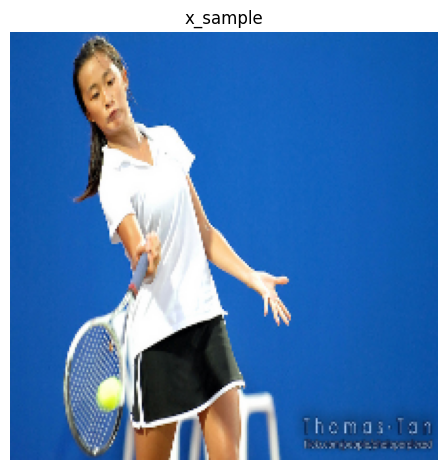

In [182]:
import numpy as np
import matplotlib.pyplot as plt

# Example tensor `y` of shape (224, 224, 11)
# Replace this with your actual tensor
#y = np.random.randint(0, 2, size=(224, 224, 11))
sample_i = 7
x_sample = x[sample_i]

plt.imshow(x_sample)#, cmap='gray')
plt.title('x_sample')
plt.axis('off')

plt.tight_layout()
plt.show()


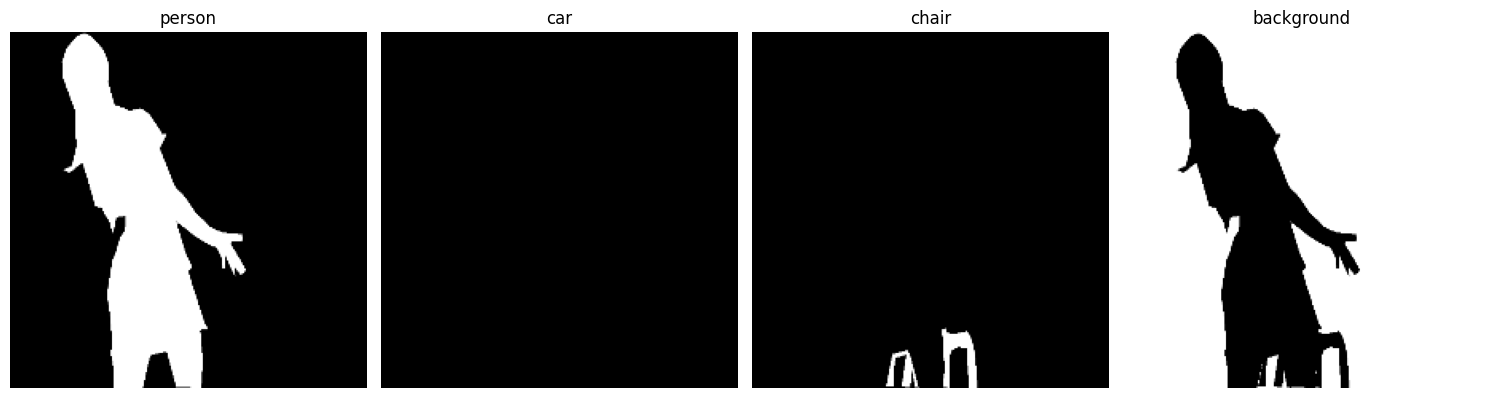

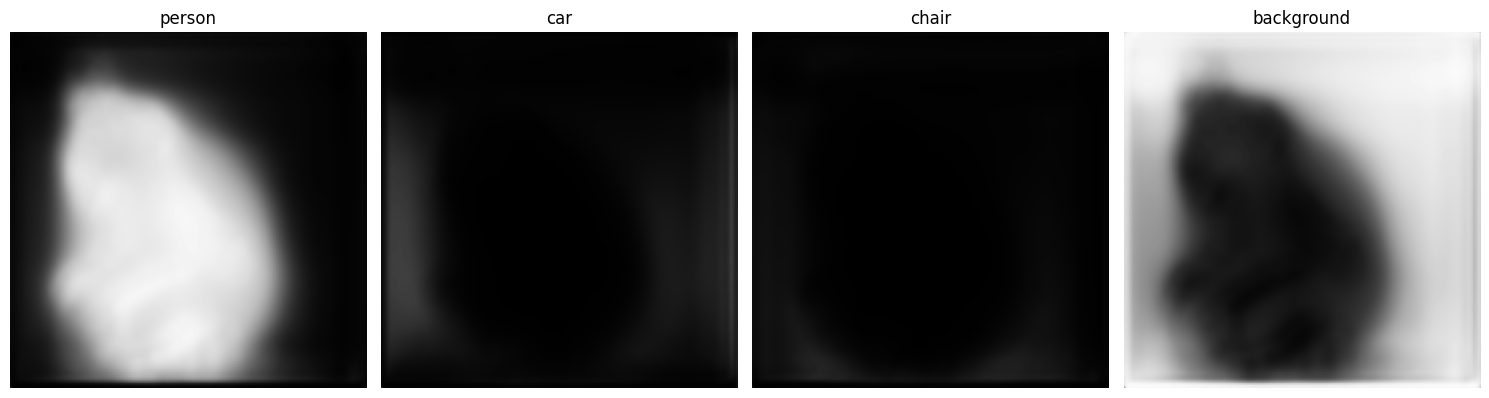

In [183]:
import numpy as np
import matplotlib.pyplot as plt

# Example tensor `y` of shape (224, 224, 11)
# Replace this with your actual tensor
#y = np.random.randint(0, 2, size=(224, 224, 11))
#y_sample = y_pred[1]
#y_sample = y_pred_i
ims = [y[sample_i], y_pred[sample_i]]

# Category names
catNms = [
    "person",
    "car",
    "chair",
    "background"
]

for im in ims:
    y_sample = im
    # Plot each channel with its class name
    num_classes = y_sample.shape[-1]
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 15))

    for i in range(num_classes):
        ax = axes[i] if num_classes > 1 else axes
        ax.imshow(y_sample[:, :, i], cmap="gray", vmin=0.,vmax=1.)
        ax.set_title(catNms[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [184]:
for i in range(32):
    sample_id = i
    print(i, iou_score(y[sample_id], y_pred[sample_id]))

0 tf.Tensor(0.501455, shape=(), dtype=float32)
1 tf.Tensor(0.47148284, shape=(), dtype=float32)
2 tf.Tensor(0.33194092, shape=(), dtype=float32)
3 tf.Tensor(0.6253392, shape=(), dtype=float32)
4 tf.Tensor(0.74256223, shape=(), dtype=float32)
5 tf.Tensor(0.43642628, shape=(), dtype=float32)
6 tf.Tensor(0.57798743, shape=(), dtype=float32)
7 tf.Tensor(0.6050552, shape=(), dtype=float32)
8 tf.Tensor(0.44048747, shape=(), dtype=float32)
9 tf.Tensor(0.6155463, shape=(), dtype=float32)
10 tf.Tensor(0.61047846, shape=(), dtype=float32)
11 tf.Tensor(0.3360826, shape=(), dtype=float32)
12 tf.Tensor(0.63089496, shape=(), dtype=float32)
13 tf.Tensor(0.75586206, shape=(), dtype=float32)
14 tf.Tensor(0.5564835, shape=(), dtype=float32)
15 tf.Tensor(0.72338784, shape=(), dtype=float32)
16 tf.Tensor(0.5827217, shape=(), dtype=float32)
17 tf.Tensor(0.59155214, shape=(), dtype=float32)
18 tf.Tensor(0.55733156, shape=(), dtype=float32)
19 tf.Tensor(0.79828584, shape=(), dtype=float32)
20 tf.Tensor(0.547

In [110]:
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import os
from glob import glob


class COCOSegmentationEvaluator:
    """
    Evaluator class for COCO instance segmentation tasks using official pycocotools.
    """

    def __init__(self, num_classes, selected_cat_ids):
        """
        Initialize the evaluator.

        Args:
            num_classes (int): Number of classes in the segmentation task
            selected_cat_ids (list): List of category IDs to evaluate
        """
        self.num_classes = num_classes
        self.selected_cat_ids = selected_cat_ids
        self.reset()

    def reset(self):
        """Reset all evaluation metrics."""
        self.annotations = []
        self.predictions = []
        self.img_id = 0
        self.ann_id = 0

    def encode_binary_mask(self, mask):
        """
        Encode binary mask to RLE format used by COCO.

        Args:
            mask (np.ndarray): Binary mask of shape (H, W)

        Returns:
            dict: RLE encoded mask
        """
        rle = maskUtils.encode(np.asfortranarray(mask))
        rle["counts"] = rle["counts"].decode("utf-8")
        return rle

    def update(self, y_true, y_pred, pred_threshold=0.5):
        """
        Update metrics with a new batch of predictions.

        Args:
            y_true (np.ndarray): Ground truth masks of shape (H, W, num_classes)
            y_pred (np.ndarray): Predicted masks of shape (H, W, num_classes) with confidence scores
            pred_threshold (float): Threshold for converting prediction probabilities to binary masks
        """
        height, width = y_true.shape[:2]

        # Process ground truth
        for class_idx in range(self.num_classes):
            gt_mask = y_true[..., class_idx]
            if gt_mask.sum() > 0:  # If there's an instance
                self.annotations.append(
                    {
                        "id": self.ann_id,
                        "image_id": self.img_id,
                        "category_id": class_idx + 1,  # COCO uses 1-based indexing
                        "segmentation": self.encode_binary_mask(gt_mask),
                        "area": float(gt_mask.sum()),
                        "bbox": maskUtils.toBbox(self.encode_binary_mask(gt_mask)).tolist(),
                        "iscrowd": 0,
                    }
                )
                self.ann_id += 1

        # Process predictions
        for class_idx in range(self.num_classes):
            pred_scores = y_pred[..., class_idx]
            pred_mask = (pred_scores > pred_threshold).astype(np.uint8)
            if pred_mask.sum() > 0:  # If there's a prediction
                confidence = float(pred_scores[pred_mask > 0].mean())
                self.predictions.append(
                    {
                        "image_id": self.img_id,
                        "category_id": class_idx + 1,  # COCO uses 1-based indexing
                        "segmentation": self.encode_binary_mask(pred_mask),
                        "score": confidence,
                        "bbox": maskUtils.toBbox(self.encode_binary_mask(pred_mask)).tolist(),
                        "area": float(pred_mask.sum()),
                    }
                )

        self.img_id += 1

    def get_metrics(self):
        """
        Compute final evaluation metrics using COCO evaluation protocol.

        Returns:
            dict: Dictionary containing various evaluation metrics
        """
        # Create COCO ground truth dataset
        coco_gt = COCO()
        coco_gt.dataset = {
            "images": [{"id": i, "height": 0, "width": 0} for i in range(self.img_id)],
            "categories": [
                {"id": cat_id, "name": str(cat_id)} for cat_id in self.selected_cat_ids
            ],
            "annotations": self.annotations,
        }
        coco_gt.createIndex()

        # Create COCO predictions dataset
        coco_dt = coco_gt.loadRes(self.predictions)

        # Create COCO evaluator
        coco_eval = COCOeval(coco_gt, coco_dt, "segm")

        # Run evaluation
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # Extract metrics
        metrics = {
            "mAP": coco_eval.stats[0],  # AP at IoU=0.50:0.95
            "mAP_50": coco_eval.stats[1],  # AP at IoU=0.50
            "mAP_75": coco_eval.stats[2],  # AP at IoU=0.75
            "mAP_small": coco_eval.stats[3],  # AP for small objects
            "mAP_medium": coco_eval.stats[4],  # AP for medium objects
            "mAP_large": coco_eval.stats[5],  # AP for large objects
            "AR_max_1": coco_eval.stats[6],  # AR given 1 detection per image
            "AR_max_10": coco_eval.stats[7],  # AR given 10 detections per image
            "AR_max_100": coco_eval.stats[8],  # AR given 100 detections per image
            "AR_small": coco_eval.stats[9],  # AR for small objects
            "AR_medium": coco_eval.stats[10],  # AR for medium objects
            "AR_large": coco_eval.stats[11],  # AR for large objects
        }

        return metrics



In [111]:

# Define the selected category IDs based on the list of classes to evaluate
data_dir = os.path.join("F:\\ssl_images\\data", "coco")
annotations_path = os.path.join(data_dir, "annotations", f"instances_train2017.json")
coco = COCO(annotations_path)
selected_cat_ids = coco.getCatIds(
    catNms=[
        "person",
        "car",
        "chair",
        "book",
        "bottle",
        "cup",
        "dining table",
        "traffic light",
        "bowl",
        "handbag",
    ]
)


loading annotations into memory...
Done (t=19.92s)
creating index...
index created!


In [114]:

# Initialize evaluator with the selected categories
evaluator = COCOSegmentationEvaluator(num_classes=10, selected_cat_ids=selected_cat_ids)

# Process each sample
for i in range(32):
    # Load ground truth mask
    y_i = y[i].numpy().astype(np.uint8)  # Cast y_true to uint8

    y_pred_i = y_pred[i].numpy()

    # Get the index of the highest value in the last axis (channels)
    max_channel_indices = np.argmax(y_pred_i, axis=-1)

    # Create a one-hot encoded mask: for each pixel, set the index of the max channel to 1, others to 0
    y_pred_i = np.zeros_like(y_pred_i, dtype=np.uint8)  # Initialize an array of zeros with the same shape
    y_pred_i[np.arange(y_pred_i.shape[0])[:, None], np.arange(y_pred_i.shape[1]), max_channel_indices] = 1

    # Skip if y_true is all zeros
    if np.sum(y_i[:, :, :10]) == 0:
        continue

    # Update evaluator with this sample
    evaluator.update(y_i, y_pred_i)
# Get metrics
metrics = evaluator.get_metrics()

# Print results
print("\nCOCO Evaluation Results:")
print("-" * 50)
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

creating index...
index created!
Loading and preparing results...


IndexError: list index out of range

In [105]:
import os
import shutil

# Define the directory
split = 'val'
output_dir = os.path.join('F:', 'ssl_images', 'data', 'processed')
output_dir_segmentation = os.path.join(output_dir, "coco", "segmentation", f"{split}2017")
output_dir_segmentation


'F:ssl_images\\data\\processed\\coco\\segmentation\\val2017'

In [ ]:
# # Check if the directory exists
# if os.path.exists(output_dir_segmentation) and os.path.isdir(output_dir_segmentation):
#     # Iterate through the files and delete them
#     for filename in os.listdir(output_dir_segmentation):
#         file_path = os.path.join(output_dir_segmentation, filename)
#         try:
#             if os.path.isfile(file_path):
#                 os.remove(file_path)  # Delete file
#             elif os.path.isdir(file_path):
#                 shutil.rmtree(file_path)  # Delete subdirectory
#         except Exception as e:
#             print(f"Error deleting {file_path}: {e}")
# else:
#     print(f"The directory {output_dir_segmentation} does not exist.")
